#### Hi
this will be a CIFAR10 using VGG16 (pre trained model)  
My model (hand made) (the previous one) had 82.2% of accuracy.   
Lets see how this VGG16 will do  

2023/01/30 2027i let get init  

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [34]:
#GPU
import torch

if torch.cuda.is_available():
    device = 'cuda'
    device_count = torch.cuda.device_count()
    if device_count > 1:
        # GPU's
        templist = [1, 2, 3]
        templist = torch.FloatTensor(templist).to(device)
        print("Cuda torch working: ", end="")
        print(templist.is_cuda)
        print("GPU device count: ", end="")
        print(device_count)
        for i in range(device_count):
            print("GPU name {}: {}".format(i, torch.cuda.get_device_name(i)))
        print("current device no.: ", end="")
        print(torch.cuda.current_device())
    else:
        # A GPU
        print("Cuda torch working: ", end="")
        print(torch.cuda.is_available())
        print("GPU device count: ", end="")
        print(device_count)
        print("GPU name: ", end="")
        print(torch.cuda.get_device_name(0))
        print("current device no.: ", end="")
        print(torch.cuda.current_device())
else:
    if torch.backends.mps.is_available():
        print("Apple device detected\nActivating Apple Silicon GPU")
        device = torch.device("mps")
    else:
        print("Cannot use GPU, activating CPU")
        device = 'cpu'


Apple device detected
Activating Apple Silicon GPU


#### Data
since the VGG16 uses 224 x 224 model and CIFAR10 is 32x32 we have to change the CIFAR10 size to 224x224  

In [35]:
num_subprocesses = 8 ###CHANGE (REDUCE) VALUE IF ERROR###
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                        shuffle=True, num_workers=num_subprocesses)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                        shuffle=False, num_workers=num_subprocesses)


Files already downloaded and verified
Files already downloaded and verified


#### VGG
I will use the predtrained vgg  
The default out features of vgg16 is 1000. But we need only one.  
So we will need line no 5. to change the out features to 10  
And since we will not change the parameters we will not require grad  
  


In [36]:
vgg16 = models.vgg16(pretrained=True)

# if multiple GPUs are available, wrap model with DataParallel 
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    vgg16 = nn.DataParallel(vgg16)

vgg16.to(device)


# change the number of classes 
vgg16.classifier[6].out_features = 10

# freeze convolution weights
# BUT convolutional layers WILL learn // allowing the model to focus on learning the mapping between the extracted features and the output predictions
for param in vgg16.features.parameters():
    param.requires_grad = False

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### LOSS and Optim


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

In [38]:
#validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [39]:
# training function
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)

    #print('Train Loss: %.4f'%train_loss)
    
    return train_loss, train_accuracy

In [40]:
NB_EPOCH = 1

# Set the initial best validation accuracy to 0
best_val_accuracy = 0.0

# Initialize the best model state dictionary
best_model_state_dict = None

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(NB_EPOCH):
    train_epoch_loss, train_epoch_accuracy = train(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    print("Train Loss : %f/  Train Acc : %.2f/  Val Loss : %f/  Val Acc : %.2f"%(train_epoch_loss,train_epoch_accuracy,val_epoch_loss,val_epoch_accuracy))
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    #print("Train Acc : %f"%train_accuracy,"Val Acc : %f"%val_accuracy)
        # Check if the current validation accuracy is better than the previous best
    if val_epoch_accuracy > best_val_accuracy:
        # Update the best validation accuracy
        best_val_accuracy = val_epoch_accuracy

        # Save the state dictionary of the current best model
        best_model_state_dict = vgg16.state_dict()


        
# Save the best model state dictionary to a file
torch.save(best_model_state_dict, "vgg16CIFAR.pth")
    
end = time.time()

print(int((end-start)//60), 'minutes', int((end-start)%60), 'seconds')

Train Loss : 0.025698/  Train Acc : 73.24/  Val Loss : 0.015397/  Val Acc : 83.25
34 minutes 30 seconds


In [41]:
loaded_data = torch.load('vgg16CIFAR.pth')

# If the loaded data is a model state dictionary, it should be a python dictionary
print(type(loaded_data))


<class 'collections.OrderedDict'>


In [53]:
###############Not Tested
import os
import pandas as pd
from PIL import Image
from torch.autograd import Variable
from tqdm import tqdm

# Class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load trained VGG16 model
# ... (This part is in your original code)

# Load the pre-trained weights
model_checkpoint = "vgg16CIFAR.pth"
vgg16.load_state_dict(torch.load(model_checkpoint))

# Make sure to do this before inference
vgg16.eval()
vgg16.to(device)

# Path to your new images
image_path = './test/test/'
image_files = os.listdir(image_path)

# Prepare to record the results
results = []

# Set batch size
batch_size = 32  # Adjust this value according to your GPU memory

# Prepare batches
num_batches = len(image_files) // batch_size + 1

for b in tqdm(range(num_batches)):

    # Prepare the batch
    batch = image_files[b*batch_size: (b+1)*batch_size]
    batch_tensors = []
    
    for image_file in batch:
        # Open image
        image = Image.open(os.path.join(image_path, image_file))

        # Apply the same transformations as you did for your training images
        image_tensor = transform(image).float()

        # Add an extra batch dimension since pytorch treats all images as batches
        image_tensor = image_tensor.unsqueeze_(0)

        batch_tensors.append(image_tensor)
    
    # Concatenate the batch
    batch_tensors = torch.cat(batch_tensors, dim=0).to(device)

    # Predict the classes of the images
    outputs = vgg16(batch_tensors)
    _, predicted = torch.max(outputs, 1)
    
    for i, predict in enumerate(predicted):
        results.append([(b*batch_size)+i+1, classes[predict.item()]])

# Save results to csv file
df = pd.DataFrame(results, columns=['id', 'label'])
df.to_csv('sampleSubmission.csv', index=False)

100%|█████████▉| 9375/9376 [2:47:09<00:01,  1.07s/it]     


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [49]:
# import os
# import pandas as pd
# from PIL import Image
# from torch.autograd import Variable
# from tqdm import tqdm

# # Class labels for CIFAR-10
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# # Load trained VGG16 model
# # ... (This part is in your original code)

# # Load the pre-trained weights
# model_checkpoint = "vgg16CIFAR.pth"
# vgg16.load_state_dict(torch.load(model_checkpoint))

# # Make sure to do this before inference
# vgg16.eval()
# vgg16.to(device)

# # Path to your new images
# image_path = './test/test/'
# image_files = os.listdir(image_path)

# # Prepare to record the results
# results = []

# # Process each image one by one (You can modify this part to batch processing)
# for i, image_file in tqdm(enumerate(image_files)):
#     # Open image
#     image = Image.open(os.path.join(image_path, image_file))

#     # Apply the same transformations as you did for your training images
#     image_tensor = transform(image).float()

#     # Add an extra batch dimension since pytorch treats all images as batches
#     image_tensor = image_tensor.unsqueeze_(0)

#     # Move the tensor to GPU if available
#     image_tensor = image_tensor.to(device)

#     # Turn the input into a Variable
#     input = Variable(image_tensor)

#     # Predict the class of the image
#     output = vgg16(input)
#     _, predicted = torch.max(output, 1)
#     results.append([i+1, classes[predicted.item()]])


# # Save results to csv file
# df = pd.DataFrame(results, columns=['id', 'label'])
# df.to_csv('sampleSubmission.csv', index=False)

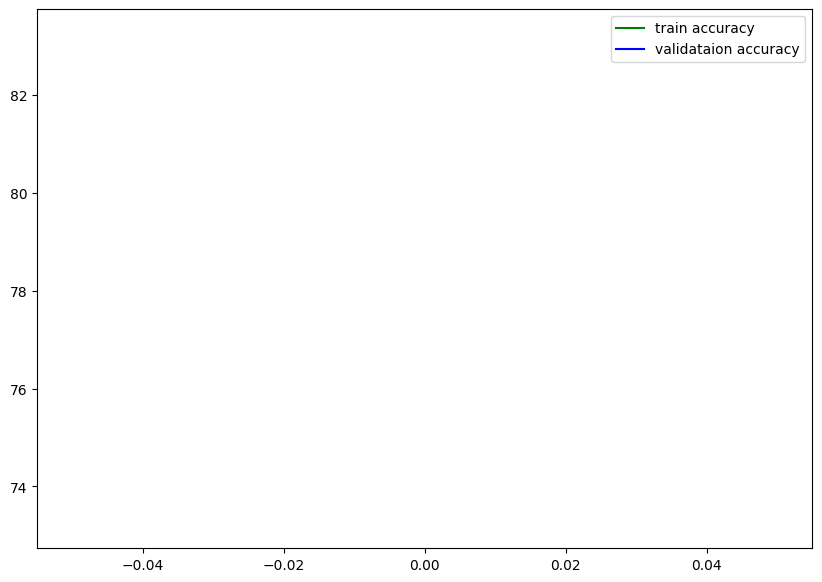

In [50]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

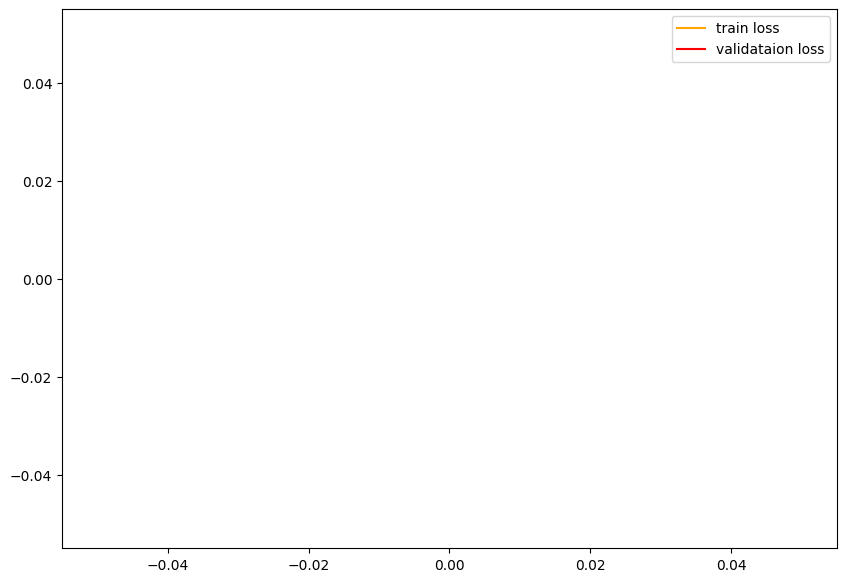

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()